# Word Embedding - Home Assigment
## Dr. Omri Allouche 2018. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/deep_learning_course/blob/master/DL_word_embedding_assignment.ipynb)
    
    
In this exercise, you'll use word vectors trained on a corpus of 380,000 lyrics of songs from MetroLyrics (https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics).  
The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

### Train word vectors
Train word vectors using the Skipgram Word2vec algorithm and the gensim package.
Make sure you perform the following:
- Tokenize words
- Lowercase all words
- Remove punctuation marks
- Remove rare words
- Remove stopwords

Use 300 as the dimension of the word vectors. Try different context sizes.

In [1]:
!pip install 'livelossplot==0.2.2'
!pip install  'torchnet==0.0.4'


    100% |████████████████████████████████| 1.4MB 18.0MB/s 
    100% |████████████████████████████████| 204kB 32.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/e1/03/fb/1c212c2f20905cdf97fe39022946cf16b8e66ed754a6663400
  Stored in directory: /root/.cache/pip/wheels/ee/87/ce/a5023722374ca73b57fc8d4284ba6f973c01219b3c385a07e0
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built torchnet visdom torchfile


In [9]:
import numpy as np 
import torch
import torch.utils.data as utils_data
from torch.autograd import Variable
import numpy as np
from torch import nn, optim
import matplotlib.pyplot as plt
import pandas  as pd
import nltk
import seaborn as sns
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
import string 
from livelossplot import PlotLosses
from gensim.models import Word2Vec
import numpy as np 
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier,XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
import torch
import nltk
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset,DataLoader
import nltk



Using TensorFlow backend.


In [10]:
%matplotlib inline
sns.set_style("darkgrid")
nltk.download('punkt')
nltk.download('stopwords')
use_cuda = torch.cuda.is_available()

SEED = 999
import random 
def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

fixSeed(SEED)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


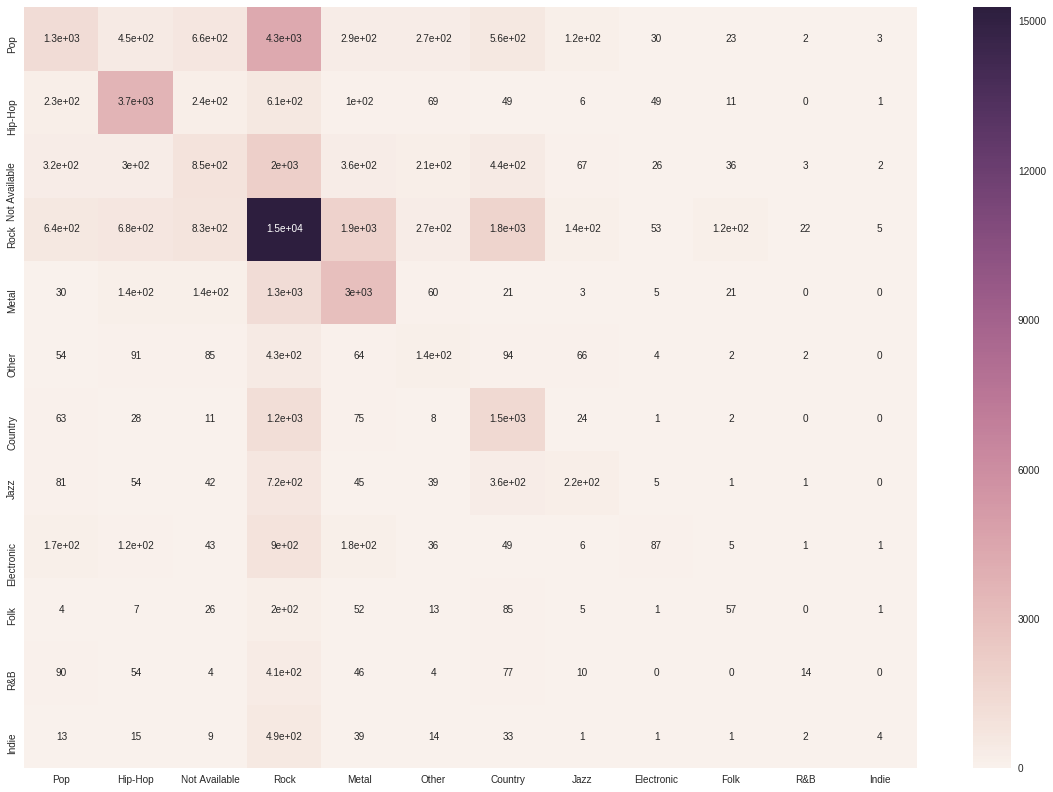

In [84]:
def plt_confusion_matrix(cm, class_names, normalize =False):
  
  if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      
  
  df_cm = pd.DataFrame(cm, index = [i for i in class_names],
                    columns = class_names)
  
  plt.figure(figsize = (20,14))
  sns.heatmap(df_cm, annot=True)

plt_confusion_matrix(conf_mat, geners)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
MIN_OCCURENCES = 5
UNKOWN_WORDS = '<UNK>'
FEATURE_VECTOR_SIZE = 300
MAX_WORDS_TO_TAKE = 128
BATCH_SIZE = 100
WINDOW_SIZE = 2


In [31]:
lyrics_df = pd.read_csv("/content/drive/My Drive/lyrics.csv", usecols=['genre', 'lyrics'])
lyrics_df.sample(10)

genre                                             lyrics
2907           Pop                                                NaN
105421     Hip-Hop                                                NaN
84935         Rock  A higher power underground\nFrom seraph skies ...
283493         Pop  When the bough broke we were crossing America\...
247333        Rock  The monster exposed himself from underground\n...
97886      Country  Sometimes I feel like my life spills into the ...
195654        Rock                                                NaN
97238         Rock  My feet, have been dragging for days.\nBecause...
124344  Electronic  I will wade out\nTill my thighs\nAre steeped\n...
124513       Metal  Piece by bloody piece\nEntered into my sanguin...

In [17]:
lyrics_df.describe(include = 'all')

genre        lyrics
count   266557        266557
unique      12        244873
top       Rock  INSTRUMENTAL
freq    109235          1369

In [20]:
lyrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362237 entries, 0 to 362236
Data columns (total 2 columns):
genre     362237 non-null object
lyrics    266557 non-null object
dtypes: object(2)
memory usage: 5.5+ MB


In [32]:
lyrics_df = lyrics_df[lyrics_df.lyrics.notnull()]
lyrics_df.sample(10)

genre                                             lyrics
295958         Pop  Father\nMy wings are clipped\nSee the steps th...
350971        Rock  This temptation\nproves to be too much\nAnd al...
299141  Electronic  La la la la la la la la la la la\nLa la la la ...
83290          Pop  Hey (yei ye yee 2x soniyee)\nYe (lolo lololo l...
76289         Rock  I woke up this morning\nAnd I walked down to t...
211974       Metal  I am possessed by death, perverted to unbelief...
331141        Rock  What's ...........................\nAnd .........
90806          Pop  Let 'em know that we're still rock n roll\nI d...
108099     Hip-Hop  Yo! Well this is Smokey Dopey Arab\nAnd the dy...
256212        Rock  Give a man a uniform\nHe'll give you a hard ti...

genre        lyrics
count   266557        266557
unique      12        244873
top       Rock  INSTRUMENTAL
freq    109235          1369

genre                                             lyrics
316758  Not Available  Show me just what you're made of, paint it up ...
171436          Metal  I Got Through To You\nAnd Destroyed You To\nI ...
251140           Rock  And I saw it coming up like a freight train\nA...
225780          Metal  I am the wind that tears your sails\nThe broke...
186632  Not Available  I'm doin' fine\nand you look great\nI think ab...
202330          Metal  Splitting of median entity\nPractice of doubt\...
343631            Pop  Yeah yeah yeah yeah\nHe makes me do things I d...
143458          Metal  As my mind flows by\nIt wanders through the ti...
260952            Pop  Well I'm a east coast walkin'\ntravelin', a ta...
351377        Hip-Hop  Ladies and Gentlemen of the Southern States of...

In [0]:
texts = lyrics_df["lyrics"].tolist()
tokenizer = RegexpTokenizer(r'\w+')
flat_list =  [word for word in [tokenizer.tokenize(text.lower()) for text  in texts]]
all_text = [item for sublist in flat_list for item in sublist]
req_dist = nltk.FreqDist(all_text)
rare_words = {word for (word, count) in req_dist.items() if count < MIN_OCCURENCES}
replace_words = {word for (word, count) in req_dist.items() if count == MIN_OCCURENCES}

{'kanikuly',
 'graissã',
 'stadien',
 'slpet',
 'malalt',
 'asociaciã³n',
 'botanicals',
 'dormira',
 'tokekonda',
 'beigeschmack',
 'lauwarm',
 'mester',
 'kramet',
 'iront',
 'sreca',
 'biondo',
 'montains',
 'heundeureonwayo',
 'retrievable',
 'oustinin',
 'ikitsuku',
 'baryshnikov',
 'undzwar',
 'ngozi',
 'knirker',
 'blluuuz',
 'huvet',
 'ramroddin',
 'calculando',
 'corin',
 'secuencia',
 'menschenleeren',
 'erfreu',
 'puddled',
 'muneojindaedo',
 'desprendes',
 'muldeureogaji',
 'chladaigh',
 'makaron',
 'iblis',
 'acarciame',
 'exorted',
 'arreglã',
 'cosignin',
 'yourelf',
 'tlucco',
 'jigi',
 'vsynyt',
 'hollowpoint',
 'firetrucks',
 'flest',
 'frinds',
 'atteggiamento',
 'patroclus',
 'entseelten',
 'viela',
 'ghn',
 'stoler',
 'burf',
 'middling',
 'tapã³n',
 'fairbanks',
 'iyeeleleleeee',
 'lacca',
 'violents',
 'wahapn',
 'genf',
 'reconnection',
 'cristiana',
 'barso',
 'smattering',
 'poitrines',
 'baby__',
 'vrijuit',
 'hablador',
 'gastes',
 'jjajeungnaelttae',
 'envo

In [0]:
def cleanText(text, rare_words=None, replace_words = None):
    table = str.maketrans({key: None for key in string.punctuation})
    text = text.translate(table)

    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens]

    stops = set(stopwords.words("english"))

    words = [word for word in tokens if word not in stops and (rare_words is None or word not in rare_words)]

    if replace_words and words:
        words = [word if word not in replace_words else UNKOWN_WORDS for word in words]


    if len(words) == 0:
        return None

    return words
    

'string With Punctuation'

In [38]:
lyrics_df["clean_lyrics"] = lyrics_df["lyrics"].map(lambda text: cleanText(text, rare_words, replace_words))
lyrics_df = lyrics_df[lyrics_df.clean_lyrics.notnull()]
lyrics_df.sample(10)

genre                                             lyrics  \
131799        Hip-Hop  [Aceyalone]\nYou can lock your door from the t...   
166009           Rock  ( On "Higher Ground" The Blind Boys Of Alabama...   
345880  Not Available  We all lead such elaborate lives\nWild ambitio...   
338280           Rock  I picked it up slow but now it's just a ritual...   
87496            Rock  There's a fool born every minute babe\nBut thi...   
196554        Country  Twenty-five minutes past quitting time\nSeven ...   
102720  Not Available  (Neal)\nWhat causes you to act the way you do?...   
323604           Rock  Look at ya now\nLook at ya\nTorn estates\nTook...   
249356        Hip-Hop  Expanding the depth of your brainpower\nOurs i...   
312707           Rock  I reglue the broken bones of my soul after yet...   

                                             clean_lyrics  
131799  [aceyalone, lock, door, thief, never, liar, go...  
166009  [higher, ground, blind, boys, alabama, curtis,...  
345880  [lead, elaborate, lives, wild, ambitions, sigh...  
338280  [picked, slow, ritual, didnt, want, captains, ...  
87496   [theres, fool, born, every, minute, babe, time...  
196554  [minutes, past, quitting, time, seven, us, cra...  
102720  [neal, causes, act, way, draws, anger, soul, i...  
323604  [look, ya, look, ya, torn, estates, took, fore...  
249356  [expanding, depth, brainpower, better, gift, b...  
312707  [broken, bones, soul, yet, another, 100, story...

In [0]:
FEATURE_VECTOR_SIZE = 300 
WINDOW_SIZE = 2
all_sentenses = lyrics_df["clean_lyrics"].tolist()
wevec_model = Word2Vec(all_sentenses, size=FEATURE_VECTOR_SIZE, window=WINDOW_SIZE, workers=4)

265397

In [0]:
clean_text = lyrics_df["clean_lyrics"].tolist()
flat_list = [item for sublist in clean_text for item in sublist]
clean_req_dist = nltk.FreqDist(flat_list)

### Review most similar words
Get initial evaluation of the word vectors by analyzing the most similar words for a few interesting words in the text. 

Choose words yourself, and find the most similar words to them.

In [41]:
word_similars = {}
for word, _ in clean_req_dist.most_common(50):
  
    similar = wevec_model.wv.most_similar(word)
    word_similars[word] = similar
    
word_similars

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


{'<UNK>': [('w', 0.3981887698173523),
  ('od', 0.34844544529914856),
  ('nae', 0.34557467699050903),
  ('nan', 0.3421091139316559),
  ('n', 0.335368812084198),
  ('jest', 0.3089711666107178),
  ('v', 0.30823826789855957),
  ('jo', 0.30493080615997314),
  ('ja', 0.2991344630718231),
  ('dynata', 0.2948426604270935)],
 'aint': [('im', 0.5747225880622864),
  ('cause', 0.5680946111679077),
  ('wasnt', 0.5487749576568604),
  ('youre', 0.5254871845245361),
  ('thats', 0.5185229778289795),
  ('isnt', 0.5168669819831848),
  ('theres', 0.513460636138916),
  ('know', 0.5115798711776733),
  ('got', 0.5083425641059875),
  ('never', 0.5072388648986816)],
 'away': [('let', 0.48427218198776245),
  ('gone', 0.48209598660469055),
  ('back', 0.479796826839447),
  ('astray', 0.4763369560241699),
  ('well', 0.47064208984375),
  ('time', 0.4704250693321228),
  ('cause', 0.46927645802497864),
  ('today', 0.4618341326713562),
  ('know', 0.46102893352508545),
  ('home', 0.4605671465396881)],
 'baby': [('babe'

In [42]:
wevec_model.wv.most_similar('fire')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('flames', 0.6274703741073608),
 ('flame', 0.6212589144706726),
 ('fires', 0.6149237751960754),
 ('desire', 0.5363163352012634),
 ('alight', 0.5229468941688538),
 ('ablaze', 0.49833786487579346),
 ('burning', 0.490545392036438),
 ('torch', 0.48680174350738525),
 ('gasoline', 0.4819372296333313),
 ('burnin', 0.47222429513931274)]

In [0]:
wevec_model.wv.most_similar('kiss')

[('kissed', 0.5996934771537781),
 ('touch', 0.5846958160400391),
 ('kisses', 0.5504751205444336),
 ('hug', 0.5244470834732056),
 ('caress', 0.5160906314849854),
 ('kissing', 0.4945163130760193),
 ('love', 0.4940756559371948),
 ('baby', 0.4696815013885498),
 ('kissin', 0.46546944975852966),
 ('taste', 0.4626149833202362)]

In [0]:
wevec_model.wv.most_similar('girl')

[('baby', 0.7139131426811218),
 ('boy', 0.7059749960899353),
 ('woman', 0.6433032751083374),
 ('know', 0.6125483512878418),
 ('cause', 0.5841875672340393),
 ('love', 0.5832270383834839),
 ('girls', 0.5812261700630188),
 ('yeah', 0.5732951164245605),
 ('want', 0.5672628879547119),
 ('youre', 0.5650014877319336)]

In [0]:
wevec_model.wv.most_similar('day')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('time', 0.6266740560531616),
 ('night', 0.620597243309021),
 ('everyday', 0.5926679372787476),
 ('morning', 0.5725794434547424),
 ('today', 0.5702868103981018),
 ('days', 0.5561830997467041),
 ('year', 0.5419521331787109),
 ('moment', 0.5355156660079956),
 ('life', 0.5351184606552124),
 ('way', 0.528084933757782)]

### Word Vectors Algebra
We've seen in class examples of algebraic games on the word vectors (e.g. man - woman + king = queen ). 

Try a few vector algebra terms, and evaluate how well they work. Try to use the Cosine distance and compare it to the Euclidean distance.

In [43]:
v1 = wevec_model.wv['man'] 
v2 = wevec_model.wv['woman'] 
v3 = wevec_model.wv['king'] 

res =  v1 - v2 + v3
wevec_model.wv.similar_by_vector(res)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('king', 0.7956687808036804),
 ('man', 0.5048424601554871),
 ('kings', 0.41699284315109253),
 ('ruler', 0.3888830542564392),
 ('messiah', 0.38084906339645386),
 ('prophet', 0.3737831711769104),
 ('chief', 0.37042540311813354),
 ('undisputed', 0.3704187273979187),
 ('queens', 0.3692237138748169),
 ('hail', 0.3673720955848694)]

In [44]:
v1 = wevec_model.wv['girl'] 
v2 = wevec_model.wv['baby'] 

res =  v1 + v2 
wevec_model.wv.similar_by_vector(res)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('girl', 0.9306955933570862),
 ('baby', 0.918463945388794),
 ('boy', 0.7279973030090332),
 ('babe', 0.6947583556175232),
 ('know', 0.6891475915908813),
 ('love', 0.673132061958313),
 ('cause', 0.6672967672348022),
 ('yeah', 0.6605707406997681),
 ('want', 0.6536444425582886),
 ('woman', 0.6461348533630371)]

In [45]:
v1 = wevec_model.wv['lover'] 
v2 = wevec_model.wv['man'] 
v3 = wevec_model.wv['woman'] 

res =  v1 - v2  + v3
wevec_model.wv.similar_by_vector(res)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('lover', 0.7889189720153809),
 ('woman', 0.6615818738937378),
 ('girl', 0.4710633158683777),
 ('lady', 0.4490094780921936),
 ('friend', 0.4321625232696533),
 ('baby', 0.43071648478507996),
 ('darlin', 0.41321665048599243),
 ('babe', 0.40872514247894287),
 ('shes', 0.4064115881919861),
 ('love', 0.4057885408401489)]

In [46]:
v1 = wevec_model.wv['love'] 
v2 = wevec_model.wv['woman'] 

res =  v1 + v2
wevec_model.wv.similar_by_vector(res)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('woman', 0.8841882944107056),
 ('love', 0.8688031435012817),
 ('girl', 0.697725772857666),
 ('baby', 0.6929010152816772),
 ('know', 0.6711302399635315),
 ('cause', 0.6309007406234741),
 ('want', 0.6185309886932373),
 ('lovin', 0.617651104927063),
 ('man', 0.6168626546859741),
 ('way', 0.6094549894332886)]

In [0]:
v1 = wevec_model.wv['love'] 
v2 = wevec_model.wv['woman'] 

res =  v1 + v2
wevec_model.wv.similar_by_vector(res)

[('woman', 0.877863347530365),
 ('love', 0.8622276782989502),
 ('girl', 0.7056551575660706),
 ('baby', 0.6891446709632874),
 ('know', 0.6853798627853394),
 ('cause', 0.6328531503677368),
 ('lovin', 0.6304674744606018),
 ('want', 0.6176474094390869),
 ('man', 0.615849494934082),
 ('way', 0.6060291528701782)]

In [0]:
v1 = wevec_model.wv['baby'] 
v2 = wevec_model.wv['girl'] 
v3 = wevec_model.wv['man'] 

res =  v1 - v2 + v3
wevec_model.wv.similar_by_vector(res)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('man', 0.7545353770256042),
 ('baby', 0.5510138273239136),
 ('yeah', 0.46613001823425293),
 ('oh', 0.4390658438205719),
 ('love', 0.42743343114852905),
 ('yes', 0.42291349172592163),
 ('well', 0.42170244455337524),
 ('know', 0.41399848461151123),
 ('lord', 0.4125754237174988),
 ('babe', 0.41126126050949097)]

In [0]:
v2 = wevec_model.wv['love'] 
v2 = wevec_model.wv['woman'] 

res =  v1 + v2
wevec_model.wv.similar_by_vector(res)

[('woman', 0.886969268321991),
 ('baby', 0.8707532286643982),
 ('girl', 0.7706629037857056),
 ('babe', 0.6707208752632141),
 ('love', 0.6638684868812561),
 ('know', 0.6623520255088806),
 ('want', 0.630240261554718),
 ('yeah', 0.6264259815216064),
 ('cause', 0.6246328353881836),
 ('honey', 0.6214901208877563)]

## Sentiment Analysis
Estimate sentiment of words using word vectors.  
In this section, we'll use the SemEval-2015 English Twitter Sentiment Lexicon.  
The lexicon was used as an official test set in the SemEval-2015 shared Task #10: Subtask E, and contains a polarity score for words in range -1 (negative) to 1 (positive) - http://saifmohammad.com/WebPages/SCL.html#OPP

Build a classifier for the sentiment of a word given its word vector. Split the data to a train and test sets, and report the model performance on both sets.

In [47]:
twitter_lex_df = pd.read_csv('/content/drive/My Drive/SemEval2015-English-Twitter-Lexicon.txt', sep='\t',  names =['polarity', 'word'])
twitter_lex_df.describe(include = 'all')

polarity             word
count   1515.000000             1515
unique          NaN             1515
top             NaN  not complaining
freq            NaN                1
mean       0.000319              NaN
std        0.502247              NaN
min       -0.984000              NaN
25%       -0.422000              NaN
50%        0.031000              NaN
75%        0.406000              NaN
max        0.984000              NaN

In [48]:
twitter_lex_df.head()

polarity            word
0     0.984           loves
1     0.984  #inspirational
2     0.969         amazing
3     0.969       #peaceful
4     0.953      #greatness

In [0]:
twitter_lex_df['vector'] = twitter_lex_df["word"].map(lambda word: wevec_model.wv[word].reshape(1,-1) if word in wevec_model.wv else None)
twitter_lex_df = twitter_lex_df[twitter_lex_df.vector.notnull()]


In [0]:
  
train, test = train_test_split(twitter_lex_df, test_size=0.2, random_state=999)
X_train = train['vector'].values
y_train = train['polarity'].values
X_test = test['vector'].values
y_test = test['polarity'].values

X_train = np.concatenate(X_train).reshape(X_train.shape[0], X_train[0].shape[1])

shape = list(X_test[0].shape)
X_test = np.concatenate(X_test).reshape(X_test.shape[0],X_test[0].shape[1])

In [51]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [52]:
model.score(X_test, y_test)

0.37610162843154593

In [53]:

regr = RandomForestRegressor(max_depth=3, random_state=999, n_estimators=150, min_samples_leaf=3)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
           oob_score=False, random_state=999, verbose=0, warm_start=False)

In [54]:
regr.score(X_test, y_test)

0.24390653010985916

In [0]:
y = y_train.reshape(-1, 1)
yy = y_test.reshape(-1, 1)


In [0]:
training_samples = utils_data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y))
data_loader = utils_data.DataLoader(training_samples, batch_size=5, shuffle=False)	

test_samples = utils_data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(yy))
test_data_loader = utils_data.DataLoader(test_samples, batch_size=len(X_test), shuffle=False)	
test_data_loader_1 = utils_data.DataLoader(test_samples, batch_size=1, shuffle=False)


In [64]:
liveloss = PlotLosses()



class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)
        self.dropout1 = nn.Dropout(p=0.1)
        

    def forward(self, x):
        x = F.relu(self.hidden(x))   
        x = self.dropout1(x)
        x = self.predict(x)  
        return x

      
      
net = Net(n_feature=300, n_hidden=20, n_output=1)     
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
loss_func = torch.nn.MSELoss()

if use_cuda:
  net = net.cuda()
  
# plt.ion()  

for epoch in range(100):
    for batch_idx, (data, target) in enumerate(data_loader):
        
        if use_cuda:
          data = data.cuda()
          target = target.cuda()
          
          
        data, target = Variable(data).float(), Variable(target).float()
        optimizer.zero_grad()
        prediction = net(data)
        loss = loss_func(prediction, target) 
        
        loss.backward() 
        optimizer.step()
        

def score(model, data_loader, criterion):
  
  running_loss = 0.
  calc_count =0.
  
  model.eval()
  
  with torch.no_grad():
    for images, labels in data_loader:
      if use_cuda:
        images = images.cuda()
        labels = labels.cuda()
        
      images = Variable(images)  
      labels = Variable(labels)
      
      outputs = model(images.float())
      loss = criterion(outputs, labels.float())
      return loss 

score(net, test_data_loader, loss_func ).item()  

0.12064286321401596

Use your trained model from the previous question to predict the sentiment score of words in the lyrics corpus that are not part of the original sentiment dataset. Review the words with the highest positive and negative sentiment. Do the results make sense?

In [0]:
X_train.shape

### Visualize Word Vectors
In this section, you'll plot words on a 2D grid based on their inner similarity. We'll use the tSNE transformation to reduce dimensions from 300 to 2. You can get sample code from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial or other tutorials online.

Perform the following:
- Keep only the 3,000 most frequent words (after removing stopwords)
- For this list, compute for each word its relative abundance in each of the genres
- Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution)
- Pick the top 50 words for each genre. These words give good indication for that genre. Join the words from all genres into a single list of top significant words. 
- Compute tSNE transformation to 2D for all words, based on their word vectors
- Plot the list of the top significant words in 2D. Next to each word output its text. The color of each point should indicate the genre for which it is most significant.

You might prefer to use a different number of points or a slightly different methodology for improved results.  
Analyze the results.

In [0]:


texts = lyrics_df["clean_lyrics"].tolist()

all_text = [item for sublist in texts for item in sublist]
req_dist = nltk.FreqDist(all_text)
words_couter = [(word, count) for (word, count) in req_dist.items()]
words_couter.sort(key=lambda tup: tup[1], reverse=True) 
top_words = words_couter[0:3000]

In [0]:
geners = lyrics_df['genre'].unique()
word_gener_counter = np.zeros(shape=(3000, len(geners)))
word_total_counter = np.zeros(len(geners))
word_index = {word: index for index, (word,counter) in enumerate(top_words)}
index_word = {index:word for index, (word,counter) in enumerate(top_words)}

genere_index = {genere: index for index, genere in enumerate(geners)}
index_genere = {index:genere  for index, genere in enumerate(geners)}

for index, row in lyrics_df.iterrows():
    genre = row['genre']
    words = row['clean_lyrics']
    
    current_genere_index = genere_index[genre]
     
    
    for word in words:
        if word in word_index:
            word_total_counter[current_genere_index] += 1
            current_word_index = word_index[word]
            word_gener_counter[current_word_index][current_genere_index]  += 1

In [0]:
ratios = word_gener_counter / word_total_counter.reshape(12)
(ratios[1, 10],word_gener_counter[1, 10]/ word_total_counter[10])

ratios_sorted = np.argsort(ratios, axis=0, kind='quicksort')
top_ineces = ratios_sorted[0:50, :]


ratios = word_gener_counter / word_total_counter.reshape(12)
(ratios[1, 10],word_gener_counter[1, 10]/ word_total_counter[10])
genget_top_words = {}
for row in top_ineces:
    for column, val in enumerate(row):
        genre = index_genere[column]
        if genre not in genget_top_words:
            genget_top_words[genre] = []
        
        word =index_word[val]
        genget_top_words[genre].append(word)
        

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


ValueError: ignored

In [0]:




def tsnescatterplot(model, genere_words):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    num_of_geners = len(genere_words.keys()) * 50
    arrays = np.empty((0, 300), dtype='f')
    #arrays = np.empty((0,num_of_geners)  , dtype='f')
                      
#     word_labels = [word]
    word_labels = []

#     color_list  = ['red']
    color_list_ptions = ['white',  'green', 'purple', 'black',  'blue', 'yellow', 'orange', 'red', 'olive', 
                  'pink', 'cyan', 'brown']
    

    color_list = []                  
    for index, (genere, list_names) in  enumerate(genere_words.items()):
        color = color_list_ptions[index]
        for wrd in list_names:
            wrd_vector = model.wv.__getitem__([wrd])   
            word_labels.append(wrd)
            color_list.append(color)
            arrays = np.append(arrays, wrd_vector, axis=0)
                      
         
                    
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=50).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

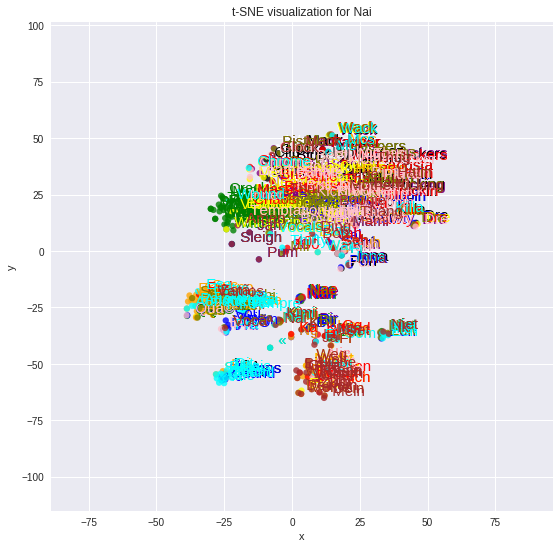

In [73]:
tsnescatterplot(wevec_model, genget_top_words)

## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

In [0]:
lyrics_df['clean_sentense'] = lyrics_df['clean_lyrics'].map(lambda words: ' '.join(words)) 
train, test = train_test_split(lyrics_df, test_size=0.2, random_state=999)


X_train = train['clean_sentense'].tolist()
y_train = train['genre'].tolist()


X_test = test['clean_sentense']
y_test = test['genre']

In [0]:
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)


In [76]:

nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [81]:

X_test_dtm = vect.transform(X_test)
y_pred_class = nb.predict(X_test_dtm)
accuracy = accuracy_score(y_test, y_pred_class)
accuracy



0.49339713279204267

0.49339713279204267

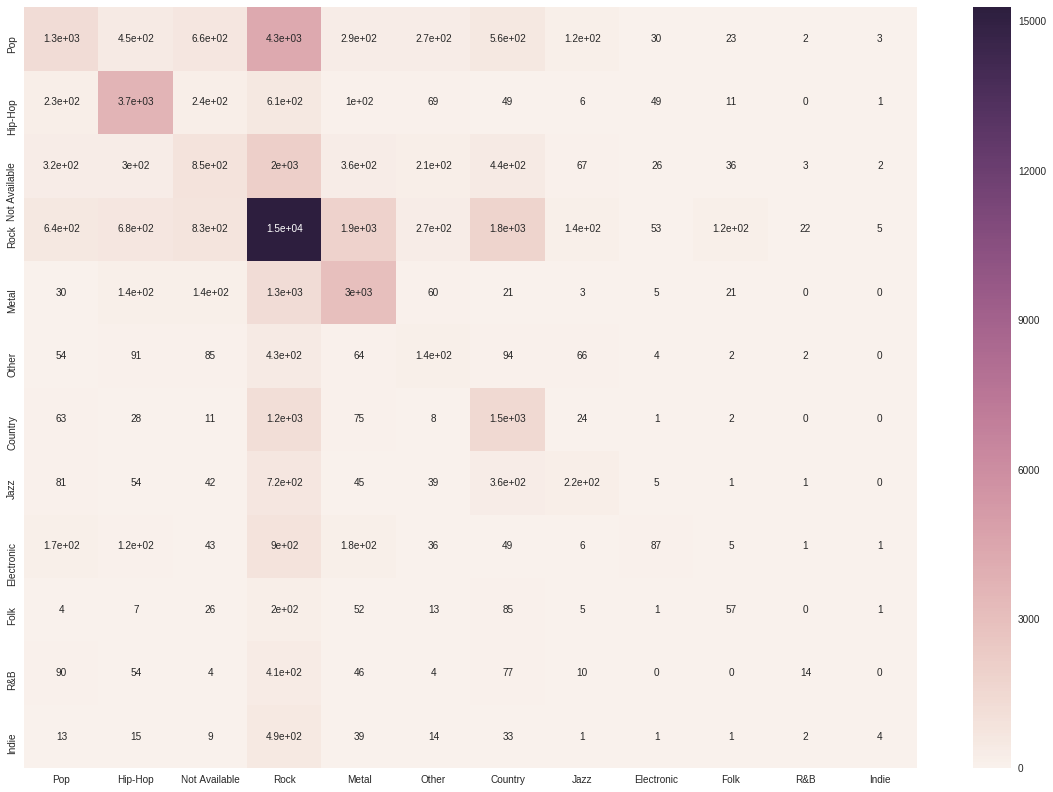

In [85]:

geners = lyrics_df['genre'].unique()
conf_mat = confusion_matrix(y_test, y_pred_class, labels = geners)
plt_confusion_matrix(conf_mat, geners)

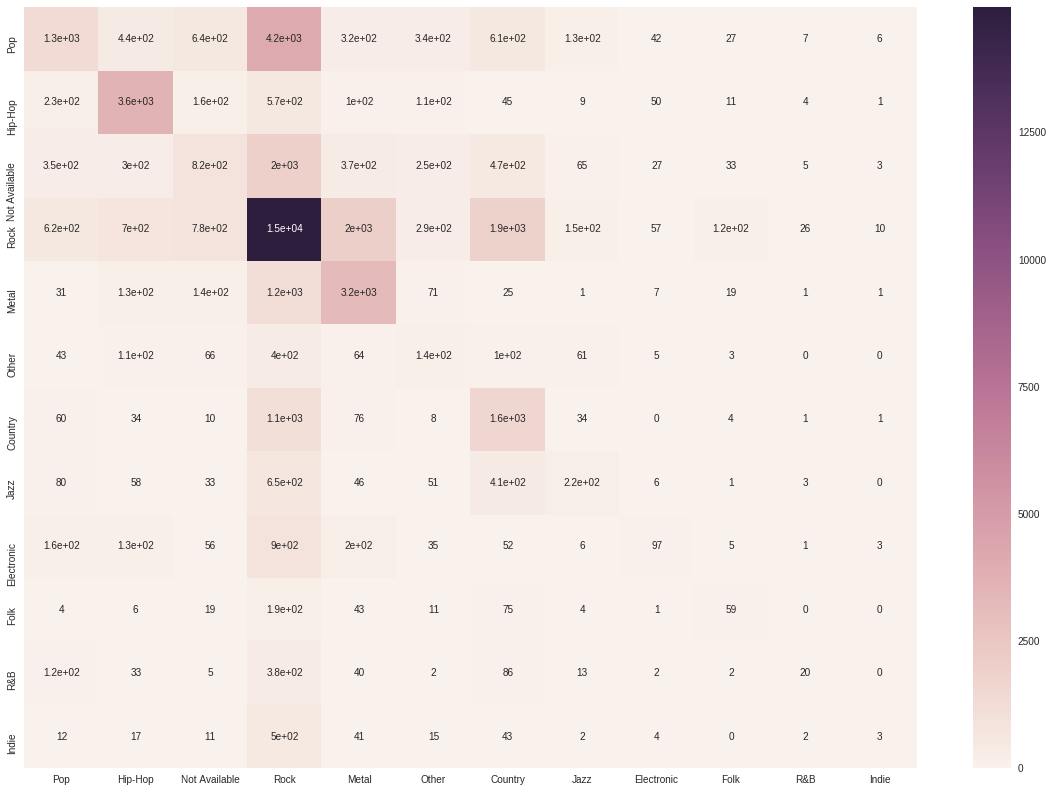

Show the classification report - precision, recall, f1 for each class.

In [86]:
print(classification_report(y_test, y_pred_class))


               precision    recall  f1-score   support

      Country       0.30      0.53      0.38      2893
   Electronic       0.33      0.05      0.09      1597
         Folk       0.20      0.13      0.16       451
      Hip-Hop       0.65      0.73      0.69      5035
        Indie       0.24      0.01      0.01       618
         Jazz       0.33      0.14      0.20      1564
        Metal       0.49      0.64      0.56      4758
Not Available       0.29      0.18      0.22      4640
        Other       0.13      0.14      0.13      1039
          Pop       0.44      0.16      0.24      8033
          R&B       0.30      0.02      0.04       708
         Rock       0.55      0.70      0.62     21747

    micro avg       0.49      0.49      0.49     53083
    macro avg       0.35      0.29      0.28     53083
 weighted avg       0.47      0.49      0.46     53083



### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

In [87]:
def avg_sentense(sentense_words):
    vectors = []
    for word in sentense_words:
      if word in wevec_model.wv:
        vectors.append(wevec_model.wv[word].reshape(1,-1))

    if len(vectors) > 1:
        return np.mean(vectors, axis=0)
    elif len(vectors) ==1:
        return vectors[0]
    else:
      return None

lyrics_df = lyrics_df[lyrics_df.clean_lyrics.notnull()]
lyrics_df['avg_vector'] = lyrics_df["clean_lyrics"].map(lambda sentense: (avg_sentense(sentense)))
train, test = train_test_split(lyrics_df, test_size=0.2, random_state=999)

X_train = train['avg_vector'].tolist()
y_train = train['genre'].tolist()

X_test = test['avg_vector'].tolist()
y_test = test['genre']



eversince
nnnow
nnnnnno
kkinda
kkinda
rringing
eheheheheheheheheheh
eheheheheheheheheheh
eheheheheheheheheheh
eheheheheheheheheheh
girlnono
girlnono
waynono
girlnono
unfairfair
carecare
lfort
tcongratule
taccepte
lcrdit
dfoyers
didaux
qupar
dtpirs
dchappement
do3
ddangereux
fourgon
trinitrotolune
gnent
lviseur
autvoie
lenculeur
dautfois
entonne
pantone
cmonde
cmonde
shurikn
ctruc
tantt
tantt
soccupe
vicieux
surin
laorte
qu20
cmonde
gaux
lcaniveau
drechange
sachtera
esclavage
sprennent
damlioration
mouton
tannonce
jprfrerais
tinquite
chemistrywhats
leavewhats
boytell
donneleur
aaaaaaaaaoooo
restgive
breakdownbridge
knowrepeat
thoroughest
heroins
squarecut
tonightlets
alumna
lrgate
lrgate
lrgate
destruy
pepsis
hookbeyonce
fiftyeleven
harmon
lewinskyed
lactivitã©
coã¯t
tintã©resses
fã©ministes
dã©testent
obvi
chingchingching
obvi
beesyay
beesyay
waw
lassemblage
grugrugrubbing
swerv
hookbridge
youyeaaa
uhooo
uhooo
uhooo
uhoooooooooooo
uhoooooooooooooo
headi
strangeit
wordsyouve
necki
mefee

In [88]:
# nb = MultinomialNB()
# # nb.fit([[1,2,3], [2,3,4]], [1,2])
# train, test = train_test_split(lyrics_df, test_size=0.2, random_state=999)
# train_x_data = train['avg_vector'].tolist()

X_train.shape


AttributeError: ignored

In [0]:

X_train = np.asanyarray(X_train)
X_train = X_train.reshape((212318,300))

X_test1 = np.asanyarray(X_test)
X_test1 = X_test1.reshape((-1, 300))


# # X_train[0.shape
# nb = MultinomialNB()
# nb.fit(xx, y_train)


In [0]:
X_test1.shape


In [0]:

scaler = MinMaxScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)
X_test1 = scaler.transform(X_test1)
#X_scaled = preprocessing.scale(X_train)

In [0]:
translator = {}
translator2 = {}
for index, y in  enumerate(set(y_train)):
    translator[index] = y
    translator2[y] = index
    
# (X_train.shape, len(y_train))
# nb = MultinomialNB()
# nb.fit(X_scaled, y_train)

In [0]:
y_train_numbers = [translator2[y] for y in y_train]

In [0]:
# (X_train.shape, len(y_train))
nb = MultinomialNB()
nb.fit(X_scaled, y_train_numbers)

In [0]:
y_pred_class = nb.predict(X_test1)
res = [translator[y1] for y1 in y_pred_class]
acc_score = accuracy_score(y_test, res)
acc_score

#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try this question on your own.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might provide you with a reference for your own code.

In [0]:

class CNN(nn.Module):
    def __init__(self, batch_size, output_size, in_channels, out_channels, kernel_heights, stride, padding, keep_probab,
                 vocab_size, embedding_length, weights, requires_grad=False):
        super(CNN, self).__init__()


        self.batch_size = batch_size
        self.output_size = output_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_heights = kernel_heights
        self.stride = stride
        self.padding = padding
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length

        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
        weights = torch.from_numpy(weights)
        self.word_embeddings.weight = nn.Parameter(weights, requires_grad=requires_grad)
        #self.word_embeddings.weight.data.copy_(torch.from_numpy(weights))

        self.conv1 = nn.Conv2d(in_channels, out_channels, (kernel_heights[0], embedding_length), stride, padding)
        self.conv2 = nn.Conv2d(in_channels, out_channels, (kernel_heights[1], embedding_length), stride, padding)
        self.conv3 = nn.Conv2d(in_channels, out_channels, (kernel_heights[2], embedding_length), stride, padding)
        self.dropout = nn.Dropout(keep_probab)
        self.label = nn.Linear(len(kernel_heights) * out_channels, output_size)

    def conv_block(self, input, conv_layer):
        conv_out = conv_layer(input.float())  # conv_out.size() = (batch_size, out_channels, dim, 1)
        activation = F.relu(conv_out.squeeze(3))  # activation.size() = (batch_size, out_channels, dim1)
        max_out = F.max_pool1d(activation, activation.size()[2]).squeeze(
            2)  # maxpool_out.size() = (batch_size, out_channels)

        return max_out

    def forward(self, input_sentences, batch_size=None):
        input = self.word_embeddings(input_sentences)
        #F.pad(input, (1, 19)).shape

        # input.size() = (batch_size, num_seq, embedding_length)
        input = input.unsqueeze(1)
        # input.size() = (batch_size, 1, num_seq, embedding_length)
        max_out1 = self.conv_block(input, self.conv1)
        max_out2 = self.conv_block(input, self.conv2)
        max_out3 = self.conv_block(input, self.conv3)

        all_out = torch.cat((max_out1, max_out2, max_out3), 1)
        # all_out.size() = (batch_size, num_kernels*out_channels)
        fc_in = self.dropout(all_out)
        # fc_in.size()) = (batch_size, num_kernels*out_channels)
        logits = self.label(fc_in)
        return logits

In [0]:
geners = lyrics_df['genre'].drop_duplicates().tolist()
weights_matrix = wevec_model.wv.vectors
vector = np.zeros(shape=(FEATURE_VECTOR_SIZE, ))
weights_matrix = np.append(weights_matrix, [vector], axis=0)
pading_index = weights_matrix.shape[0] -1


In [0]:
train, validation = train_test_split(lyrics_df, test_size=0.2, random_state=999)

geners = lyrics_df['genre'].drop_duplicates().tolist()

gene_to_index = {gene : index for index, gene in enumerate(geners)}
index_to_gene = {index : gene  for index, gene in enumerate(geners)}


In [0]:
def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)

class DatasetLoader(Dataset):

    def __init__(self, df, gene_to_index, w2vec, pading_index):
        self._df = df
        self.gene_to_index = gene_to_index
        self.w2vec = w2vec
        self.pading_index = pading_index

    def __len__(self):
        return len(self._df)

    def __getitem__(self, idx):
        current_element = self._df.iloc[idx]
        words = current_element['clean_lyrics']
        words = [word if word  in self.w2vec.wv.vocab else UNKOWN_WORDS for word in words]
        genre = current_element['genre']
        if len(words) > MAX_WORDS_TO_TAKE:
            words = words[0:MAX_WORDS_TO_TAKE]

        indexes = [self.w2vec.wv.vocab[word].index for word in words]
        if len(indexes) < MAX_WORDS_TO_TAKE:
            missing = MAX_WORDS_TO_TAKE - len(indexes)
            x1 = np.repeat(self.pading_index, repeats=missing)
            indexes = np.concatenate([indexes, x1])

        return np.array(indexes), self.gene_to_index[genre]
                

In [0]:
train.shape 

(212317, 3)

In [0]:
train_dataset_loader  = DatasetLoader(train, gene_to_index, wevec_model, pading_index)

train_data_loader = torch.utils.data.DataLoader(train_dataset_loader,
                                             batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validation_dataset_loader  = DatasetLoader(validation, gene_to_index, wevec_model, pading_index)

validation_data_loader = torch.utils.data.DataLoader(validation_dataset_loader,
                                             batch_size=BATCH_SIZE, shuffle=True, num_workers=4)



In [0]:
use_cuda

True

In [0]:
def train_model(model, train_iter, epoch, loss_fn, cm):
  total_epoch_loss = 0
  total_epoch_acc = 0
#   if use_cuda:
#     model.cuda()

  optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
  steps = 0
  model.train()
  for idx, (sentenses, labels) in enumerate(train_iter):
    sentenses = Variable(sentenses)
    labels = Variable(labels)

    if torch.cuda.is_available():
      sentenses = sentenses.long().cuda()
      labels = labels.cuda()

    optim.zero_grad()
    prediction = model(sentenses)
    loss = loss_fn(prediction, labels)
    model_predictions = torch.max(prediction, 1)[1]
    num_corrects = (model_predictions == labels).float().sum()
    acc = 100.0 * num_corrects / len(sentenses)
    loss.backward()
    clip_gradient(model, 1e-1)
    optim.step()
    steps += 1
    cm.add(model_predictions, labels)
        
    if steps % 100 == 0:
      print('Epoch: {0}, Idx: {1}, Training Loss: {2}, Training Accuracy: {3}%'.format(epoch, idx, loss.item(),acc.item()))

    total_epoch_loss += loss.item()
    total_epoch_acc += acc.item()

  return round(total_epoch_loss / len(train_iter), 4), round(total_epoch_acc / len(train_iter), 4)

  
def eval_model(model, val_iter, cm):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for idx, (sentenses, labels) in enumerate(val_iter):
            
            if use_cuda:
              sentenses = sentenses.cuda()
              labels = labels.cuda()
              
            sentenses = Variable(sentenses)
            labels = Variable(labels)
       
            prediction = model(sentenses)
            loss = loss_fn(prediction, labels)
            model_predictions = torch.max(prediction, 1)[1]
            num_corrects = (model_predictions == labels).float().sum()
            
            confusion_matrix.add(model_predictions, labels)
            acc = 100.0 * num_corrects/len(sentenses)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return round(total_epoch_loss/len(val_iter), 4), round(total_epoch_acc/len(val_iter),4)
  

In [0]:
num_classes = len(geners)
cnn = CNN(BATCH_SIZE, num_classes, 1, 10, [3,5,7], 1, 0, 0.5,len(wevec_model.wv.vocab) + 1, 300, weights_matrix)

if use_cuda:
  cnn = cnn.cuda()

In [0]:
def plt_confusion_matrix(cm, class_names, normalize =False):
  
  if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      
  
  df_cm = pd.DataFrame(cm, index = [i for i in class_names],
                    columns = class_names)
  
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True)

In [0]:
loss_fn = F.cross_entropy
# !pip install  'torchnet==0.0.4'

from torchnet.meter import ConfusionMeter

liveloss = PlotLosses()
validation_confusion_matrix = ConfusionMeter(num_classes)
train_confusion_matrix = ConfusionMeter(num_classes)

criterion = nn.CrossEntropyLoss()
if use_cuda:
  criterion = criterion.cuda()

for epoch in range(10):
    loss, acc = train_model(cnn, train_data_loader, epoch, loss_fn, train_confusion_matrix)
    val_loss, val_acc = eval_model(cnn, validation_data_loader, validation_confusion_matrix)
    
    
    liveloss.update({
          'log loss': loss,
          'val_log loss': val_loss,
          'accuracy': acc,
          'val_accuracy': val_acc
      })
    
    liveloss.draw()

test_loss, test_acc = eval_model(cnn, test_iter)



Epoch: 0, Idx: 99, Training Loss: 1.111497163772583, Training Accuracy: 75.0%
Epoch: 0, Idx: 199, Training Loss: 1.0727131366729736, Training Accuracy: 100.0%
Epoch: 0, Idx: 299, Training Loss: 2.9255781173706055, Training Accuracy: 50.0%
Epoch: 0, Idx: 399, Training Loss: 1.5447059869766235, Training Accuracy: 75.0%
Epoch: 0, Idx: 499, Training Loss: 2.5517516136169434, Training Accuracy: 25.0%
Epoch: 0, Idx: 599, Training Loss: 2.4455533027648926, Training Accuracy: 0.0%
Epoch: 0, Idx: 699, Training Loss: 1.4286943674087524, Training Accuracy: 75.0%
Epoch: 0, Idx: 799, Training Loss: 1.3568437099456787, Training Accuracy: 50.0%
Epoch: 0, Idx: 899, Training Loss: 2.0160419940948486, Training Accuracy: 50.0%
Epoch: 0, Idx: 999, Training Loss: 1.4112235307693481, Training Accuracy: 75.0%
Epoch: 0, Idx: 1099, Training Loss: 2.3744959831237793, Training Accuracy: 75.0%
Epoch: 0, Idx: 1199, Training Loss: 2.284369468688965, Training Accuracy: 50.0%
Epoch: 0, Idx: 1299, Training Loss: 1.410

KeyboardInterrupt: ignored